# 使用重复元素的网络（VGG）

AlexNet在LeNet的基础上增加了3个卷积层。但AlexNet作者对它们的卷积窗口、输出通道数和构造顺序均做了大量的调整。虽然AlexNet指明了深度卷积神经网络可以取得出色的结果，但并没有提供简单的规则以指导后来的研究者如何设计新的网络。我们将在本章的后续几节里介绍几种不同的深度网络设计思路。

本节介绍VGG，它的名字来源于论文作者所在的实验室Visual Geometry Group [1]。VGG提出了可以通过重复使用简单的基础块来构建深度模型的思路。

## VGG块

VGG块的组成规律是：连续使用数个相同的填充为1、窗口形状为$3\times 3$的卷积层后接上一个步幅为2、窗口形状为$2\times 2$的最大池化层。卷积层保持输入的高和宽不变，而池化层则对其减半。我们使用`vgg_block`函数来实现这个基础的VGG块，它可以指定卷积层的数量`num_convs`和输出通道数`num_channels`。

In [1]:
import tensorflow as tf
print(tf.__version__)

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

2.17.0


In [2]:
def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(tf.keras.layers.Conv2D(num_channels,kernel_size=3,
                                    padding='same',activation='relu'))
    
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return blk

## VGG网络

与AlexNet和LeNet一样，VGG网络由卷积层模块后接全连接层模块构成。卷积层模块串联数个`vgg_block`，其超参数由变量`conv_arch`定义。该变量指定了每个VGG块里卷积层个数和输出通道数。全连接模块则跟AlexNet中的一样。

现在我们构造一个VGG网络。它有5个卷积块，前2块使用单卷积层，而后3块使用双卷积层。第一块的输出通道是64，之后每次对输出通道数翻倍，直到变为512。因为这个网络使用了8个卷积层和3个全连接层，所以经常被称为VGG-11。

In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

下面我们实现VGG-11。

In [4]:
def vgg(conv_arch):
    net = tf.keras.models.Sequential()
    for (num_convs, num_channels) in conv_arch:
        net.add(vgg_block(num_convs,num_channels))
    net.add(tf.keras.models.Sequential([tf.keras.layers.Flatten(),
             tf.keras.layers.Dense(4096,activation='relu'),
             tf.keras.layers.Dropout(0.5),
             tf.keras.layers.Dense(4096,activation='relu'),
             tf.keras.layers.Dropout(0.5),
             tf.keras.layers.Dense(10,activation='sigmoid')]))
    return net

net = vgg(conv_arch)

下面构造一个高和宽均为224的单通道数据样本来观察每一层的输出形状。

In [5]:
X = tf.random.uniform((1,224,224,1))
for blk in net.layers:
    X = blk(X)
    print(blk.name, 'output shape:\t', X.shape)

sequential_1 output shape:	 (1, 112, 112, 64)
sequential_2 output shape:	 (1, 56, 56, 128)
sequential_3 output shape:	 (1, 28, 28, 256)
sequential_4 output shape:	 (1, 14, 14, 512)
sequential_5 output shape:	 (1, 7, 7, 512)
sequential_6 output shape:	 (1, 10)


可以看到，每次我们将输入的高和宽减半，直到最终高和宽变成7后传入全连接层。与此同时，输出通道数每次翻倍，直到变成512。因为每个卷积层的窗口大小一样，所以每层的模型参数尺寸和计算复杂度与输入高、输入宽、输入通道数和输出通道数的乘积成正比。VGG这种高和宽减半以及通道翻倍的设计使得多数卷积层都有相同的模型参数尺寸和计算复杂度。

## 获取数据和训练模型

因为VGG-11计算上比AlexNet更加复杂，出于测试的目的我们构造一个通道数更小，或者说更窄的网络在Fashion-MNIST数据集上进行训练。

In [6]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

x_batch shape: (128, 224, 224, 1) y_batch shape: (128,)


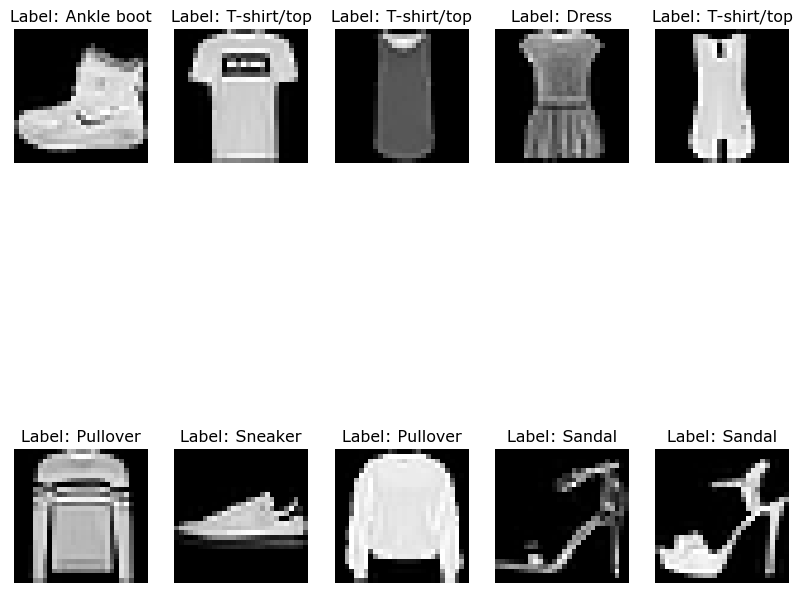

In [21]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./deeplearning.mplstyle')
# plt.style.use('seaborn-darkgrid')  # 设置matplotlib样式
class DataLoader():
    def __init__(self):
        fashion_mnist = tf.keras.datasets.fashion_mnist
        (self.train_images, self.train_labels), (self.test_images, self.test_labels) = fashion_mnist.load_data()
        self.train_images = np.expand_dims(self.train_images.astype(np.float32)/255.0,axis=-1)
        self.test_images = np.expand_dims(self.test_images.astype(np.float32)/255.0,axis=-1)
        self.train_labels = self.train_labels.astype(np.int32)
        self.test_labels = self.test_labels.astype(np.int32)
        self.num_train, self.num_test = self.train_images.shape[0], self.test_images.shape[0]
        
    def get_batch_train(self, batch_size):
        index = np.random.randint(0, np.shape(self.train_images)[0], batch_size)
        #need to resize images to (224,224)
        resized_images = tf.image.resize_with_pad(self.train_images[index],224,224,)
        return resized_images.numpy(), self.train_labels[index]
    
    def get_batch_test(self, batch_size):
        index = np.random.randint(0, np.shape(self.test_images)[0], batch_size)
        #need to resize images to (224,224)
        resized_images = tf.image.resize_with_pad(self.test_images[index],224,224,)
        return resized_images.numpy(), self.test_labels[index]

    def dataset_explorate(self):
        """展示数据集前10条数据"""
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']  # 标签名称列表
        plt.figure(figsize=(10, 10))
        for i in range(10):
            plt.subplot(2, 5, i + 1)  # 创建2行5列的子图
            plt.imshow(self.train_images[i].squeeze(), cmap='gray')  # 显示图像，去掉通道维度
            plt.title(f'Label: {class_names[self.train_labels[i]]}')  # 显示标签
            plt.axis('off')  # 不显示坐标轴
        plt.show()
batch_size = 128
dataLoader = DataLoader()
x_batch, y_batch = dataLoader.get_batch_train(batch_size)
print("x_batch shape:",x_batch.shape,"y_batch shape:", y_batch.shape)
dataLoader.dataset_explorate()

除了使用了稍大些的学习率，模型训练过程与上一节的AlexNet中的类似。

注：这里省略了训练过程的输出，如果您需要进行训练，请执行train_vgg()函数

In [ ]:
def train_vgg():
#     net.load_weights("5.7_vgg_weights.h5")
    epoch = 5
    num_iter = dataLoader.num_train//batch_size
    for e in range(epoch):
        for n in range(num_iter):
            x_batch, y_batch = dataLoader.get_batch_train(batch_size)
            net.fit(x_batch, y_batch)
            if n%20 == 0:
                net.save_weights("5.7_vgg.weights.h5")
                
optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.0, nesterov=False)

net.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

x_batch, y_batch = dataLoader.get_batch_train(batch_size)
net.fit(x_batch, y_batch)
# train_vgg()

我们将训练好的参数读入，然后取测试数据计算测试准确率

In [ ]:
net.load_weights("5.7_vgg.weights.h5")

x_test, y_test = dataLoader.get_batch_test(2000)
net.evaluate(x_test, y_test, verbose=2)

## 小结

* VGG-11通过5个可以重复使用的卷积块来构造网络。根据每块里卷积层个数和输出通道数的不同可以定义出不同的VGG模型。